In [1]:
# general python ecosystem
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import ipywidgets

# SimPEG tools 
import discretize
from discretize.utils import mesh_builder_xyz, refine_tree_xyz

from SimPEG.potential_fields import magnetics as mag
from SimPEG import (
    data,
    data_misfit,
    directives,
    maps,
    inverse_problem,
    optimization,
    inversion,
    regularization,
    utils
)

In [2]:
np.random.seed(2021)

# Forward problem

## define the geologic setup

**SimPEG conventions**
- right handed coordinate system
- z-positive up
- SI units

For this example, we assume flat topography with the surface at z=0

In [3]:
# define MAG

target_magnetization_inclination = 45
target_magnetization_declination = 90 

target_magnetization_direction = utils.mat_utils.dip_azimuth2cartesian(
    target_magnetization_inclination, target_magnetization_declination
)

target_magnetization_amplitude = 1000 # magnetization in A/m
target_magnetization1 = target_magnetization_amplitude * target_magnetization_direction

target_magnetization_inclination = -10
target_magnetization_declination = 70 

target_magnetization_direction = utils.mat_utils.dip_azimuth2cartesian(
    target_magnetization_inclination, target_magnetization_declination
)

target_magnetization_amplitude = 500 # magnetization in A/m
target_magnetization2 = target_magnetization_amplitude * target_magnetization_direction



## survey geometry

In [4]:
line_length = 1500
n_data_along_line = 50

survey_x = np.linspace(-line_length/2, line_length/2, n_data_along_line)
survey_y = np.r_[-50,0, 50] 
survey_z = np.r_[20]

survey_xyz = discretize.utils.ndgrid([survey_x, survey_y, survey_z])

## create a mesh

Here, for simplicity, we use a tensor mesh. If we end up working with larger problems, we should switch to an OcTree. 

In [5]:
from discretize import TensorMesh

nc = 40  # number of core mesh cells in x, y and z
dh = 40   # base cell width in x, y and z
npad = 10  # number of padding cells
exp = 1  # expansion rate of padding cells

h = [(dh, npad, -exp), (dh, nc), (dh, npad, exp)]
mesh = TensorMesh([h, h, h], x0="CCC")

ind_active = mesh.cell_centers_z < 0

In [6]:
mesh

TensorMesh: 216,000 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     60     -1,200.00      1,200.00     40.00     40.00    1.00
   y     60     -1,200.00      1,200.00     40.00     40.00    1.00
   z     60     -1,200.00      1,200.00     40.00     40.00    1.00

### put the model on the mesh 

In [7]:
xx = np.linspace(-700, 100,np.size(mesh.cell_centers[:, 0]))


ind_pipe = (
    (mesh.cell_centers[:, 0] > 1.8*xx)
    & (mesh.cell_centers[:, 0] < (1.8*xx)+300)
    & (mesh.cell_centers[:, 1] > -1000)
    & (mesh.cell_centers[:, 1] < 1000)
    & (mesh.cell_centers[:, 2] < 50.0)
)

ind_pipe2 = (
    (mesh.cell_centers[:, 0] > xx+500)
    & (mesh.cell_centers[:, 0] < xx+1000)
    & (mesh.cell_centers[:, 1] > -1000)
    & (mesh.cell_centers[:, 1] < 1000)
    & (mesh.cell_centers[:, 2] < 50.0)
)

magnetization = np.zeros((mesh.nC, 3))
magnetization[ind_pipe, :] = target_magnetization2
magnetization[ind_pipe2, :] = target_magnetization1

create an active cell map to ignore air cells (not as important in the forward, but will be in the inversion)

In [8]:
ind_active = mesh.cell_centers[:, 2] <= 0
magnetization[~ind_active, :] = np.nan
n_active = int(ind_active.sum())

model = magnetization[ind_active, :]
active_cell_map = maps.InjectActiveCells(mesh=mesh, indActive=ind_active, valInactive=np.nan)

plot the model

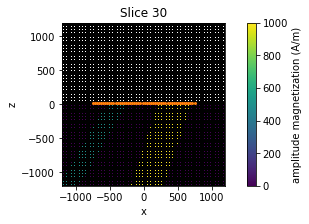

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 3))
cb = plt.colorbar(mesh.plot_slice(
    np.linalg.norm(magnetization, axis=1), normal="Y", ax=ax, grid=True, 
)[0], ax=ax)

ax.plot(
    np.outer(np.ones_like(survey_z), survey_x), np.outer(survey_z, np.ones_like(survey_x)), "C1o", ms=2
)
cb.set_label("amplitude magnetization (A/m)")
ax.set_aspect(1)

### define some useful plotting functions

In [10]:
def full_mesh_magnetization(model):
    return np.vstack([active_cell_map * model.reshape(n_active, 3, order="F")[:, i] for i in range(3)]).T

In [11]:
def plot_vector_model(
    model, ax=None, quiver_opts=None, normal="Y", xlim=None, ylim=None, ind=None, plot_data=True, plot_grid=True
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(10, 4))

    magnetization = full_mesh_magnetization(model)
    qo = {
        "units":"xy", "scale":np.max(np.abs(model))/20,
        "headwidth":7, "headlength":10, "headaxislength":10
    }
    
    # overwrite default vals if user provides them 
    if quiver_opts is not None:
        for key, val in quiver_opts.items(): 
            qo[key] = val 

    cb = plt.colorbar(
        mesh.plot_slice(
            magnetization, "CCv", normal=normal, ax=ax, view="vec", 
            grid=plot_grid, ind=ind, quiver_opts=qo
        )[0], ax=ax
    )
    cb.set_label("amplitude magnetization (A/m)")

    if normal.upper() == "X": 
        if plot_data is True: 
            ax.plot(survey_xyz[:, 1], survey_xyz[:, 2], "C1o", ms=2, label="data locations")
        ax.set_xlim([survey_x.min()*1.5, survey_x.max()*1.5] if xlim is None else xlim)
      #  ax.set_ylim([target_geometry[:,2].min()*3, survey_z.max()*4] if ylim is None else ylim)
    elif normal.upper() == "Y": 
        if plot_data is True: 
            ax.plot(survey_xyz[:, 0], survey_xyz[:, 2], "C1o", ms=2, label="data locations")
        ax.set_xlim([survey_x.min()*1.5, survey_x.max()*1.5] if xlim is None else xlim)
      #  ax.set_ylim([target_geometry[:,2].min()*3, survey_z.max()*4] if ylim is None else ylim)
    elif normal.upper() == "Z": 
        if plot_data is True: 
            ax.plot(survey_xyz[:, 0], survey_xyz[:, 1], "C1o", ms=2, label="data locations")
        ax.set_xlim([survey_x.min()*1.25, survey_x.max()*1.25] if xlim is None else xlim)
        ax.set_ylim([survey_x.min()*1.25, survey_x.max()*1.25] if ylim is None else ylim)
    ax.legend()
    ax.set_aspect(1)

In [12]:
def plot_target_outline(ax, normal="Y", plot_opts={"color":"C3", "lw":3}):
    if normal.upper() == "X": 
        x_target = np.hstack([target_geometry[:, 1], target_geometry[::-1, 1], target_geometry[0, 1]])
        y_target = np.hstack([target_geometry[0, 2], target_geometry[:, 2], target_geometry[::-1, 2]])
    elif normal.upper() == "Y": 
        x_target = np.hstack([target_geometry[:, 0], target_geometry[::-1, 0], target_geometry[0, 0]])
        y_target = np.hstack([target_geometry[0, 2], target_geometry[:, 2], target_geometry[::-1, 2]])
    elif normal.upper() == "Z":
        x_target = np.hstack([target_geometry[:, 0], target_geometry[::-1, 0], target_geometry[0, 0]])
        y_target = np.hstack([target_geometry[0, 1], target_geometry[:, 1], target_geometry[::-1, 1]])
    
    ax.plot(x_target, y_target, **plot_opts)

### plot the model with vectors indicating magnetization direction 

Note that if you would like to change the index of the slices (cross section or depth slice, you can provide an `ind` value to the `plot_vector_model` function)

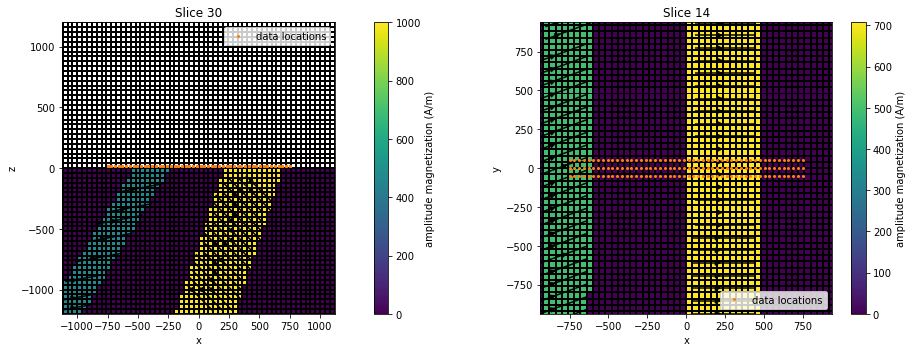

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(17, 5), gridspec_kw={'width_ratios': [2, 1]})

zind = 14 #27
plot_vector_model(model, ax=ax[0]) #, plot_grid=False)
plot_vector_model(model, ax=ax[1], normal="Z", ind=zind) #, plot_grid=False)
plt.tight_layout()

## setup and run the forward simulation

### survey

We create a survey object that keeps track of what data we are measuring and where. We create a `source_field` because the code was designed thinking about "effective susceptibility" being the model parameter. The orientation makes no impact, it is only a scaling. So since the problem is linear, if we use an amplitude of 1 for the source field, then we can consider the model to be magnetization, and there is no induced component. 

In [14]:
components = ["x", "y", "z"]
rx = mag.receivers.Point(locations=survey_xyz, components=[f"b{comp}" for comp in components])

source_field = mag.sources.SourceField(
    receiver_list=[rx], parameters=np.r_[1., 0, 0]
)
survey = mag.survey.Survey(source_field)

### simulation 

The simulation object is what we use to create our synthetic data

In [15]:
simulation = mag.simulation.Simulation3DIntegral(
    mesh=mesh, survey=survey, chiMap=maps.IdentityMap(nP=np.prod(model.shape)), 
    actInd=ind_active, modelType="vector"
)

### run the simulation

The `synthetic_data` is an object that keeps track of the simulated data. It keeps the clean data (`synthetic_data.dclean`), the data that will be used in the inversion (`synthetic_data.dobs`), whether those data are contaminated with noise (`add_noise`), and the standard deviation of the noise. 

The standard deviation of the noise assigned here will later be used in the inversion. Note that `noise_floor` should be greater than 0. 

The data misfit that we will later construct for the inversion is as follows:
$$
\phi_d = \| \mathbf{W}_d(\mathbf{d}^{\rm pred} - \mathbf{d}^{\rm obs} )\|^2
$$

with 
- $\mathbf{W}_d = {\rm diag}(1/\epsilon_j)$
- $\epsilon_j = $ `relative_error * abs(dobs) + noise_floor`


In [16]:
synthetic_data = simulation.make_synthetic_data(
    utils.mkvc(model), 
    noise_floor=1, # standard deviation of the noise in nT 
    relative_error=0,  # if you want to include a percent noise 
    add_noise=True  # do we add noise to the data we will use in the inversion?
) 

In [17]:
def plot_data_profile(data, plot_opts=None, ax=None, xlim=None, ylim=None, label=True):
    data = data.reshape((survey_xyz.shape[0], len(components)))
    
    if ax is None: 
        fig, ax = plt.subplots(len(survey_z), len(components), figsize=(5*len(components), 4*len(survey_z)))
        ax = np.atleast_2d(ax)
    
    po = {"ms": 3}
    if plot_opts is not None: 
        for key, val in plot_opts.items():
            po[key] = val 
    
    for k, zloc in enumerate(survey_z): 
        for i, component in enumerate(components):
            d = data[:, i].reshape(len(survey_x), len(survey_y), len(survey_z), order="F")
            for j, y in enumerate(survey_y):
                if not isinstance(label, bool):
                    l=f"{y:1.0f} m {label}"
                else:
                    l=f"{y:1.0f} m" if label is True else None
                ax[k, i].plot(survey_x, d[:, j, k], f"C{j}", label=l, **po)

            ax[k, i].set_title(f"B{component} z={zloc}m")
            ax[k, i].grid("both", alpha=0.6)
            ax[k, i].set_ylim(1.25 * np.r_[data.min(), data.max()] if ylim is None else ylim)
            ax[k, i].set_xlim(xlim)
            ax[k, i].set_xlabel("x (m)")
    
    ax[0, 0].set_ylabel("magnetic field (nT)")
    if label is not False: 
        ax[0, 0].legend()
    plt.tight_layout()
    return ax
    

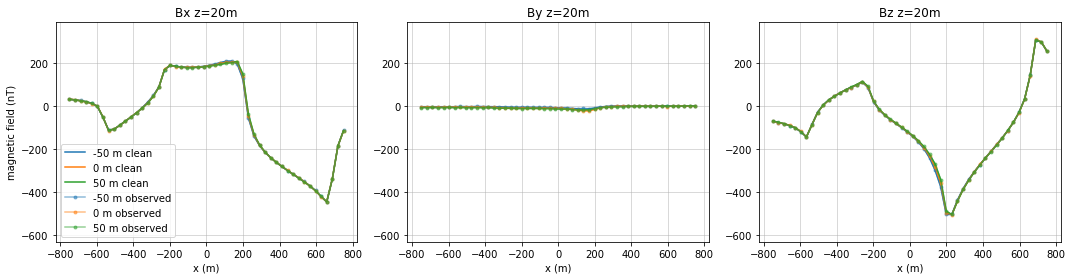

In [18]:
ax = plot_data_profile(synthetic_data.dclean, label="clean")
ax = plot_data_profile(synthetic_data.dobs, ax=ax, plot_opts={"marker":"o", "alpha":0.5}, label="observed")

In [19]:
def plot_2d_data(data, ax=None, title=None, xlabel=True):
    if ax is None: 
        fig, ax = plt.subplots(len(survey_z), len(components), figsize=(5*len(components), 2*len(survey_z)), sharex=True, sharey=True)
        ax = np.atleast_2d(ax)
        
    data = data.reshape((survey_xyz.shape[0], len(components)))
    plotting_xyz = discretize.utils.ndgrid(survey_x, survey_y)
    
    for k, zloc in enumerate(survey_z):
        
        norm = Normalize(vmin=np.min(data), vmax=np.max(data))
        
        for i, component in enumerate(components): 
            d = data[:, i].reshape(len(survey_x), len(survey_y), len(survey_z), order="F")
            out = utils.plot2Ddata(plotting_xyz, utils.mkvc(d[:, :, k]), ax=ax[k, i], contourOpts={"norm":norm, "levels":10})
            
            if i == len(components) - 1:
                plt.colorbar(out[0], ax=ax[k, i], label="B (nT)")
            
            ax[k, i].set_title(f"B{component} {title}, z={zloc} m")
            ax[k, i].plot(survey_xyz[:, 0], survey_xyz[:, 1], "k.", ms = 2)

            if xlabel is True:
                ax[-1, i].set_xlabel("x (m)")

        ax[k, 0].set_ylabel("y (m)")
    plt.tight_layout()
    
    return ax

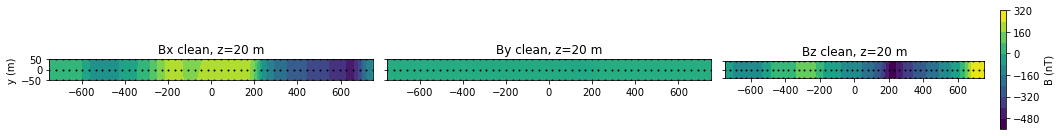

In [20]:
if len(survey_y) > 1: 
    plot_2d_data(synthetic_data.dclean, title="clean", xlabel=False)

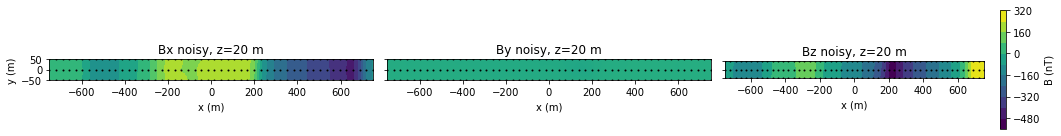

In [21]:
if len(survey_y) > 1:
    plot_2d_data(synthetic_data.dobs, title="noisy")

## Inversion 

### in cartesian coordinates 
This is a linear inverse problem if we use L2 regularization. 

In [22]:
# create the regularization
wires = maps.Wires(("x", n_active), ("y", n_active), ("z", n_active))

reg_x = regularization.Sparse(mesh, indActive=ind_active, mapping=wires.x)
reg_y = regularization.Sparse(mesh, indActive=ind_active, mapping=wires.y)
reg_z = regularization.Sparse(mesh, indActive=ind_active, mapping=wires.z)

norms = [[2, 2, 2, 2]]
reg_x.norms = norms
reg_y.norms = norms
reg_z.norms = norms

reg = reg_x + reg_y + reg_z

In [23]:
# data misfit
dmis = data_misfit.L2DataMisfit(data=synthetic_data, simulation=simulation)

In [24]:
# optimization
opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=10, maxIterCG=20, tolCG=1e-4
)

In [25]:
# inverse problem
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [26]:
# directives 
betaest = directives.BetaEstimate_ByEig(beta0_ratio=2)  # estimate initial trade-off parameter
sensitivity_weights = directives.UpdateSensitivityWeights()  # Add sensitivity weights
IRLS = directives.Update_IRLS()  # IRLS
update_Jacobi = directives.UpdatePreconditioner()  # Pre-conditioner
target = directives.TargetMisfit(chifact=1)  # target misfit 

In [27]:
inv = inversion.BaseInversion(
    inv_prob, directiveList=[sensitivity_weights, IRLS, update_Jacobi, betaest, target]
)

### run the inversion

In [28]:
m0 = np.zeros(n_active * 3)
mrec_cartesian = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.40e-02  6.37e+06  0.00e+00  6.37e+06    9.51e+02      0              
   1  1.70e-02  3.52e+04  7.49e+06  1.63e+05    3.38e+01      0              
   2  8.51e-03  1.52e+04  8.30e+06  8.58e+04    2.04e+01      0   Skip BFGS  
   3  4.25e-03  6.89e+03  8.97e+06  4.51e+04    1.20e+01      0   Skip BFGS  
   4  2.13e-03  3.29e+03  9.55e+06  2.36e+04    6.91e+00      0   Skip BFGS  
   5  1.06e-03  1.66e+03  1.

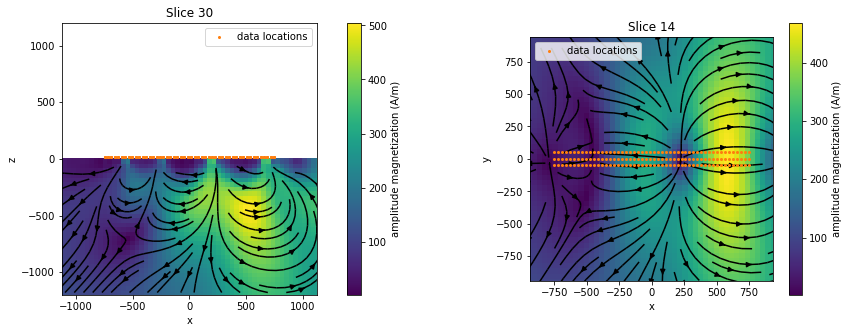

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1]})

quiver_opts = {
    "scale":np.max(np.abs(mrec_cartesian))/20,
}

plot_vector_model(mrec_cartesian, ax=ax[0], plot_grid=False)
plot_vector_model(mrec_cartesian, ax=ax[1], normal="Z", ind=zind, plot_grid=False)

# plot_target_outline(ax[0], normal="Y")
# plot_target_outline(ax[1], normal="Z")

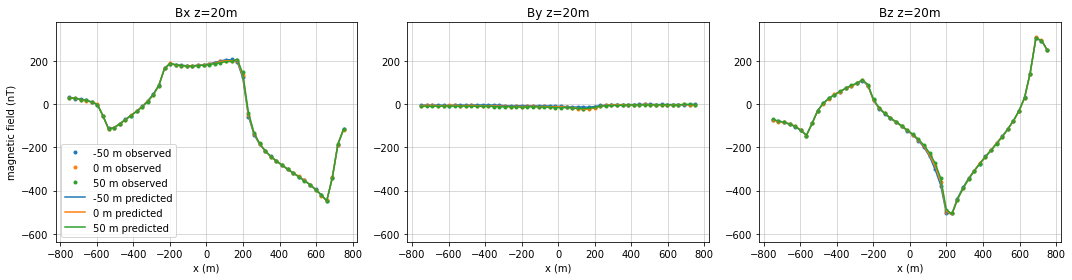

In [30]:
ax = plot_data_profile(synthetic_data.dobs, plot_opts={"marker":"o", "lw":0}, label="observed")
ax = plot_data_profile(inv_prob.dpred, ax=ax, label="predicted")

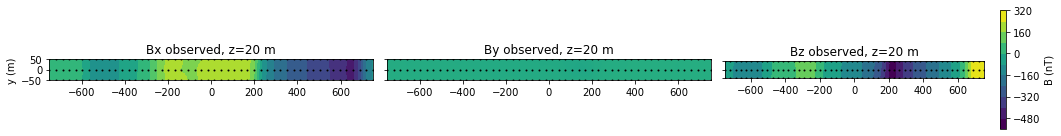

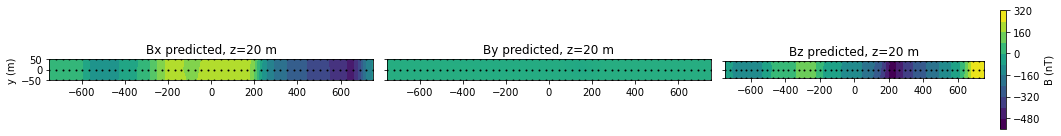

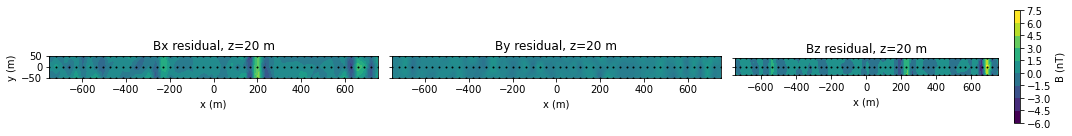

In [31]:
if len(survey_y) > 1: 
    plot_2d_data(synthetic_data.dobs, title="observed", xlabel=False)
    plot_2d_data(inv_prob.dpred, title="predicted", xlabel=False)
    plot_2d_data(synthetic_data.dobs - inv_prob.dpred, title="residual")

    plt.tight_layout()

### inversion in spherical coordinates

This allows us to impose regularization on amplitude and direction independently. 

In [32]:
## inversion in spherical coordinates
spherical_map = maps.SphericalSystem(nP=n_active*3)

wires = maps.Wires(("amplitude", n_active), ("theta", n_active), ("phi", n_active))

In [33]:
# create the regularization
reg_amplitude = regularization.Sparse(mesh, indActive=ind_active, mapping=wires.amplitude)
reg_theta = regularization.Sparse(mesh, indActive=ind_active, mapping=wires.theta)
reg_phi = regularization.Sparse(mesh, indActive=ind_active, mapping=wires.phi)

norms = [[1, 0, 0, 0]]
reg_amplitude.norms = norms
reg_theta.norms = norms
reg_phi.norms = norms

# set reference model to zero
reg_amplitude.mref = np.zeros(n_active*3)
reg_theta.mref = np.zeros(n_active*3)
reg_phi.mref = np.zeros(n_active*3)

# don't impose reference angles
reg_theta.alpha_s = 0. 
reg_phi.alpha_s = 0.

reg_spherical = reg_amplitude + reg_theta + reg_phi

In [34]:
simulation_spherical = mag.simulation.Simulation3DIntegral(
    mesh=mesh, survey=survey, chiMap=spherical_map, 
    actInd=ind_active, modelType="vector"
)

dmis_spherical = data_misfit.L2DataMisfit(simulation=simulation_spherical, data=synthetic_data)

In [35]:
# optimization
opt_spherical = optimization.InexactGaussNewton(
    maxIter=20, maxIterCG=20, tolCG=1e-4
)

In [36]:
inv_prob_spherical = inverse_problem.BaseInvProblem(
    dmis_spherical, reg_spherical, opt_spherical, beta=inv_prob.beta
)

In [37]:
# directives 
spherical_projection = directives.ProjectSphericalBounds()  
sensitivity_weights = directives.UpdateSensitivityWeights()
IRLS = directives.Update_IRLS(
    sphericalDomain=True, beta_tol=0.1
)
update_Jacobi = directives.UpdatePreconditioner()

In [38]:
inv_spherical = inversion.BaseInversion(
    inv_prob_spherical, directiveList=[
        spherical_projection, sensitivity_weights, IRLS, update_Jacobi
    ]
)

In [39]:
mstart = utils.cartesian2spherical(mrec_cartesian.reshape((n_active, 3), order="F"))
mrec_spherical = inv_spherical.run(mstart)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.32e-05  3.16e+02  7.05e+04  3.19e+02    1.63e+02      0              
   1  1.66e-05  3.12e+02  7.03e+04  3.13e+02    1.96e+02      0              
   2  8.31e-06  3.09e+02  7.05e+04  3.10e+02    1.72e+02      0              
   3  4.15e-06  3.07e+02  7.04e+04  3.07e+02    1.92e+02      0              
   4  2.08e-06  3.05e+02  7.06e+04  3.05e+02    1.63e+02      0              
   5  1.04e-06  3.03e+02  7.04e+04  3.03e+02    1.83e+02      0              
   6  5.19e-07  3.01e+02  7.06e+04  3.01e+02    1.61e+02      0              
   7  2.60e-07  2.99e+02  7.05e+04

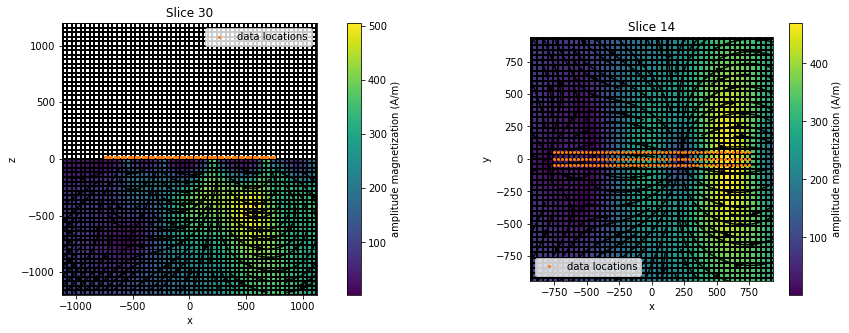

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [2, 1]})

quiver_opts = {
    "scale":np.max(np.abs(mrec_spherical))/20,
}

m = spherical_map * mrec_spherical
plot_vector_model(m, ax=ax[0])
plot_vector_model(m, ax=ax[1], normal="Z", ind=zind)

# plot_target_outline(ax[0], normal="Y")
# plot_target_outline(ax[1], normal="Z")


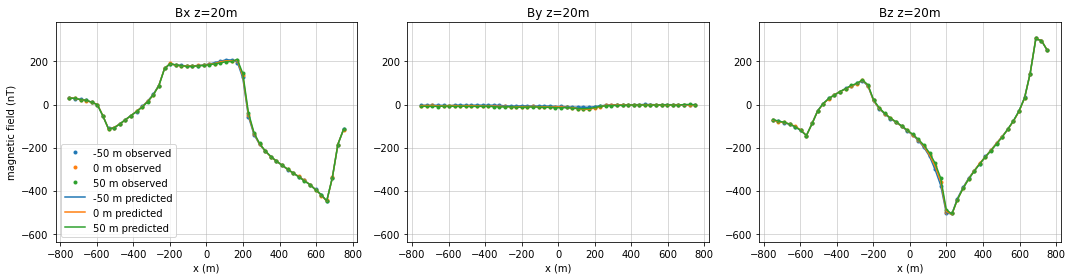

In [41]:
ax = plot_data_profile(synthetic_data.dobs, plot_opts={"marker":"o", "lw":0}, label="observed")
ax = plot_data_profile(inv_prob_spherical.dpred, ax=ax, label="predicted")

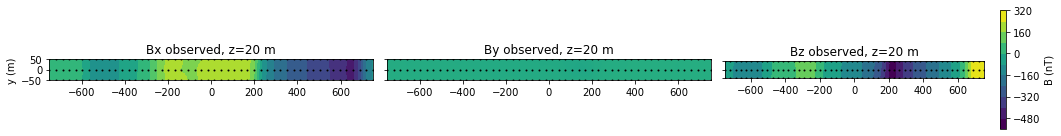

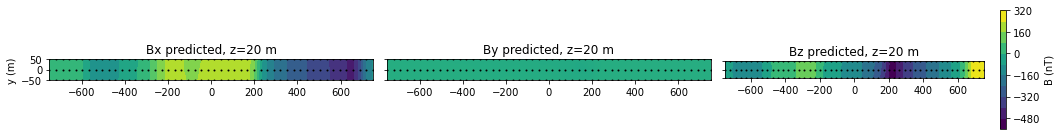

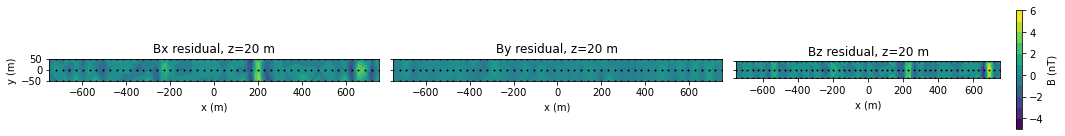

In [42]:
if len(survey_y) > 1: 
    plot_2d_data(synthetic_data.dobs, title="observed", xlabel=False)
    plot_2d_data(inv_prob_spherical.dpred, title="predicted", xlabel=False)
    plot_2d_data(synthetic_data.dobs - inv_prob_spherical.dpred, title="residual")

    plt.tight_layout()